In [9]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        xSquared = np.multiply(self.x , self.x)
        ySquared = np.multiply(self.y, self.y)
        zSquared = np.multiply(self.z, self.z)
        self.mag = np.sqrt(np.add(xSquared, ySquared, zSquared))
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        self.gyro = SensorData("Accelerometer", *parsedGyroLogData[1:])
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))
    
    def transformData(xform_func):
        self.accel.mag = xform_func(self.accel.mag)
        self.accel.x = xform_func(self.accel.x)
        self.accel.y = xform_func(self.accel.y)
        self.accel.z = xform_func(self.accel.z)
        

In [10]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

In [11]:

import sys
!{sys.executable} -m pip install fastdtw

You are using pip version 9.0.1, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
# Load the data

# You should change the path to the location of the log files on your system
# logPath = '/Users/jonf/Dropbox/CSE590_UbiComp/Git/CSE590Sp2018p/A02-GestureRecognizer/JupyterAnalysis/GestureLogs'
# logPath = "D:\Dropbox\CSE590_UbiComp\Git\CSE590Sp2018\A02-GestureRecognizer\JonGestureLogs"
jonLogPath = '/home/cynthia/ubicomp/gesture/JonGestureLogs'
myLogPath = '/home/cynthia/ubicomp/gesture/MyGestureLogs'

jonTrials = parse_and_create_gesture_trials(jonLogPath)
myTrials = parse_and_create_gesture_trials(myLogPath)

Found 100 csv files in /home/cynthia/ubicomp/gesture/JonGestureLogs
Found 10 gestures
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'At Rest'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Midair S'
Max trial length across all gesture is 'At Rest' Trial 3 with 323 sensor events. Resizing all arrays to match
Found 110 csv files in /home/cynthia/ubicomp/gesture/MyGestureLogs
Found 11 gestures
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Your Custom Gesture'
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'At Rest'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair 

In [20]:

NFFT = 32     # the length of the windowing segments
Fs = 50  # the sampling rate

def visualizeGesture(name, gestureTrials):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10), squeeze=False)
    fig.subplots_adjust(hspace=0.5)
    for trialNum, trial in enumerate(gestureTrials):
        axes[0][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[0][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[0][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][0].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        Pxx, freqs, bins, im = axes[1][1].specgram(trial.accel.mag, NFFT=NFFT, Fs=Fs,noverlap=0)
    
    axes[0][0].set_title(name + " (Accel X)")
    axes[0][0].legend()
    
    axes[0][1].set_title(name + " (Accel Y)")
    axes[0][1].legend()
    
    axes[0][2].set_title(name + " (Accel Z)")
    axes[0][2].legend()
    
    axes[1][0].set_title(name + " (Accel Mag)")
    axes[1][0].legend()
    
    axes[1][1].set_title(name + " Specgram (Accel Mag)")
    
    

# Now let's plot all of the accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
def createGestureViz(gestureMap):
    index = 0
    gestureNamesSorted = sorted(gestureMap.keys())
    for gestureName in gestureNamesSorted:
        gestureTrials = gestureMap[gestureName]
        visualizeGesture(gestureName, gestureTrials)

#createGestureViz(jonTrials)


In [14]:

# helper functions

from fastdtw import fastdtw
from scipy import signal
import random
import pdb


def makeFolds(mapping, num_folds=5):

    # returns list of lists of trials
    # each fold is a list of trials
    folds = [[] for i in range(num_folds)]
    for name, trials in mapping.items():
        # this is a shuffled order for the values
        shuffle = random.sample(range(num_folds), num_folds)
        for idx, trial in enumerate(trials):
            folds[shuffle[idx]].append(trial)
    return folds

def printSingleFold(fold, header=''):
    for t in fold:
        print("{} {} {}".format(header, t.gestureName, t.trialNum))

def printFolds(folds):
    for idx, f in enumerate(folds):
        print("Fold " + str(idx))
        printSingleFold(f, header='    ')


def movingAvgSmoothing(data):
    window_size = 5
    window = data[:window_size]
    window_sum = sum(window)
    idx = 0
    out = [window_sum/window_size]
    
    for pt in data[:-window_size]:
        window_sum = window_sum - window[idx] + pt
        window[idx] = pt
        idx += 1
        if idx >= window_size:
            idx = 0
        out.append(window_sum/window_size)    
        
    return out

def offsetTranslation(data):
    mean = np.mean(data)
    out = [x-mean for x in data]
    return out

def amplitudeScaling(data):
    mean = np.mean(data)
    std = np.std(data)
    out = [(x-mean)/std for x in data]
    return out

def detrend(data):
    return signal.detrend(data)

def euclideanDistance(a, b):
    return distance.euclidean(a,b)
    
def dynamicTimeWarping(a, b):
    dist, path = fastdtw(a, b, dist=distance.euclidean)
    return dist

class Analysis:
    def __init__(self, name):
        self.name = name
        self.predicted_as = []
        self.accurate = 0
    def addTestedResult(self, res):
        self.predicted_as.append(res)
        if res == self.name:
            self.accurate += 1
    def getAccurateStats(self):
        return (self.accurate, len(self.predicted_as))
    def printAccuracy(self):
        accurate, total = self.getAccurateStats()
        #print("Predictions for {}: {}".format(self.name, self.predicted_as))
        print('{}: {}/{} ({}%)'.format(self.name, accurate, total, (accurate/total)*100))
    def getPredictions(self):
        return self.predicted_as

def initAnalysis(trial_names):
    
    analyses = {}
    for name in trial_names:
        analyses[name] = Analysis(name)
        
    return analyses

def printAnalysis(analyses):
    total_accurate = 0
    total_runs = 0
    for a in analyses.values():
        acc, tot = a.getAccurateStats()
        total_accurate += acc
        total_runs += tot
        a.printAccuracy()
    print('Final accuracy: {}/{} ({}%)'.format(total_accurate, total_runs, (total_accurate/total_runs)*100))

In [15]:
# make folds


In [24]:
# Create folds
jon_folds = makeFolds(jonTrials)
my_folds = makeFolds(myTrials)

In [16]:
# try to do euclidean distance
from scipy.spatial import distance
def transformData(data):
    out = movingAvgSmoothing(data)
    out = offsetTranslation(out)
    out = amplitudeScaling(out)
    out = detrend(out)
    
    return out


def testTrials(tester, trainer):
    smooth_test = transformData(tester.accel.mag)
    smooth_train = transformData(trainer.accel.mag)
          
    #euc = dynamicTimeWarping(smooth_test, smooth_train)
    euc = euclideanDistance(smooth_test, smooth_train)
    return euc
def shapeMatching(gestureMap, folds):

    # For example, here's how you would plot one of the signals
    #gestureNamesSorted = sorted(gestureMap.keys())
    #print(gestureNamesSorted)

    analyses = initAnalysis(gestureMap.keys())
    #folds = makeFolds(gestureMap, 5)

    # do fold 0
    #for fold in folds:
    #    print(fold)
    for fold_idx, fold in enumerate(folds):
        for test_trial in fold:
            #print('Testing fold {}: {} {}'.format(fold_idx, test_trial.gestureName, test_trial.trialNum))
            #print(test_trial)
            winning_trial = None
            winning_trial_num = None
            for idx, train_fold in enumerate(folds):
                if fold_idx == idx:
                    continue
                best_match = None
                best_match_val = None
                for train_trial in train_fold:
                    #print(train_trial)
                    diff = testTrials(test_trial, train_trial)
                    #print('     {}: {}'.format(train_name, diff))
                    if best_match_val is None:
                        best_match = train_trial
                        best_match_val = diff
                    elif diff < best_match_val:
                        best_match = train_trial
                        best_match_val = diff
                #print('  Fold {} best match is {} {}: {}'.format(idx, best_match.gestureName, best_match.trialNum, best_match_val))
                if winning_trial is None or (winning_trial_num is not None and winning_trial_num > best_match_val):
                    winning_trial = best_match
                    winning_trial_val = best_match_val   
            analyses[test_trial.gestureName].addTestedResult(winning_trial.gestureName)

    printAnalysis(analyses)
    return analyses

#a = shapeMatching(jonTrials)

In [32]:
# Here's some sample code for building up a multi-dimensional feature vector
# Feel free to use this approach (or not) in your homework

from sklearn import svm

comment = """
- std dev
- count above threshold
num peaks
area under curve
"""

# Example create_feature_vector function that returns a 3D feature vector for the given trial        
def create_simple_feature_vector(trial):
    return [
        trial.accel.mag.max(), 
        trial.accel.x.max(), 
        trial.accel.y.max(), 
        trial.accel.z.max(), 
        trial.accel.x.min(), 
        trial.accel.y.min(), 
        trial.accel.z.min(), 
        np.mean(trial.accel.mag),
        np.mean(trial.accel.x),
        np.mean(trial.accel.y),
        np.mean(trial.accel.z),
        np.std(trial.accel.mag),
        np.std(trial.accel.x),
        np.std(trial.accel.y),
        np.std(trial.accel.z),
        trial.accel.signalLengthBeforePadding, 
        trial.gyro.mag.max(),
        np.std(trial.gyro.mag),
        np.mean(trial.gyro.mag),
    ]
    
# takes in the current testFold, the trainingFolds, and a create_feature_vector function
# the create_feature_vector function creates feature vectors given a Trial object
# I suggest creating multiple different create_feature_vector functions that you pass
# in here and test (this will allow you to easily compare different feature vectors)
def get_svm_input(testFold, trainingFolds, create_feature_vector):
    
    # calculate the number of training trials
    numOfTrainingTrials = 0
    for trainingFold in trainingFolds:
        numOfTrainingTrials = numOfTrainingTrials + len(trainingFold)
        
    # Now figure out the number of features from the create_feature_vector call
    # This is just a dummy call to figure out the number of features in order to
    # properly initialize our trainingData matrix
    tmpTrainingTrial = random.choice(trainingFolds[0])
    tmpFeatureVector = create_feature_vector(tmpTrainingTrial)
    #print(tmpFeatureVector)
    numFeatures = len(tmpFeatureVector)
    print("The feature vector size is: {}".format(numFeatures))
     
    # now we can setup our training data structures  
    # each row in our trainingData matrix corresponds to a trial
    # and each column corresponds to a feature
    trainingData = np.zeros([numOfTrainingTrials, numFeatures])
    trainingTrials = list()
    trainingLabels = np.array([])
  
    # Build up the training data and also keep track of the class labels (in trainingLabels)
    row = 0
    for trainingFold in trainingFolds:
        for trainingTrial in trainingFold:
            trainingData[row] = create_feature_vector(trainingTrial)
            trainingLabels = np.append(trainingLabels, trainingTrial.gestureName)
            trainingTrials.append(trainingTrial)
            #print(trainingData[row])
            row = row + 1
    
    # Now setup the testData data structure
    testData = np.zeros([len(testFold), numFeatures])
    testRow = 0
    groundtruthLabels = list()
    testTrials = list()
    for testTrial in testFold:
        testTrials.append(testTrial)
        testData[testRow] = create_feature_vector(testTrial)
        groundtruthLabels.append(testTrial.gestureName)
        testRow = testRow + 1
    
    return trainingData, trainingLabels, trainingTrials, testData, groundtruthLabels, testTrials
        
#print("Test fold: ")
#printSingleFold(testFold)
#print("Training folds")
#printFolds(trainingFolds)

def runSVM(gestureMap, folds):
    
    analyses = initAnalysis(gestureMap.keys())
    
    for idx, fold in enumerate(folds):

        testFold = folds[idx]
        trainingFolds = folds[:idx] + folds[idx+1:]

        # This is an example of how you would call the get_svm_input method
        # You'll have to figre out how to appropriately put this in a for loop and use it...  
        svmInput = get_svm_input(testFold, trainingFolds, create_simple_feature_vector)

        # Unpack the tuple into more semantic variable names
        trainingData, trainingLabels, trainingTrials, testData, groundtruthLabels, testTrials = svmInput

        clf = svm.SVC()
        clf.fit(trainingData, trainingLabels) 

        for trial in testFold:
            print("Attempting to predict: {}".format(trial.gestureName))
            svmPrediction = clf.predict([create_simple_feature_vector(trial)])
            #pdb.set_trace()
            print("SVM prediction: {}".format(svmPrediction[0]))
            analyses[trial.gestureName].addTestedResult(svmPrediction[0])
            
    return analyses
            

#analyses = runSvm(jonTrials, folds)
#printAnalysis(analyses)


In [18]:
# Confusion Matrix
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.figure(figsize=(2,2))
    

def makeConfusionMatrix(analyses):
    # make the array
    y_true = []
    y_pred = []
    labels = []

    for a in analyses.values():
        y_true.extend([a.name] * len(a.getPredictions()))
        y_pred.extend(a.getPredictions())
        labels.append(a.name)

    cm = confusion_matrix(y_true, y_pred, labels)
    plt.figure()
    plot_confusion_matrix(cm, classes=labels,
                          title='Confusion matrix (without normalization)')

    plt.figure()
    plot_confusion_matrix(cm, classes=labels, normalize=True,
                          title='Confusion matrix (with normalization)')
    plt.show()


In [33]:
# helper functions for analyzing

def doShapeMatching(trials, folds):
    analysis = shapeMatching(trials, folds)
    printAnalysis(analysis)
    makeConfusionMatrix(analysis)
    
def doSVM(trials, folds):
    analysis = runSVM(trials, folds)
    printAnalysis(analysis)
    makeConfusionMatrix(analysis)
    

/home/cynthia/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7176: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


The feature vector size is: 19
Attempting to predict: Underhand Bowling
SVM prediction: Shake
Attempting to predict: Midair Counter Clockwise O
SVM prediction: Midair Counter Clockwise O
Attempting to predict: At Rest
SVM prediction: Shake
Attempting to predict: Midair Clockwise O
SVM prediction: Midair Clockwise O
Attempting to predict: Baseball Throw
SVM prediction: Shake
Attempting to predict: Forehand Tennis
SVM prediction: Forehand Tennis
Attempting to predict: Midair Zorro Z
SVM prediction: Shake
Attempting to predict: Shake
SVM prediction: Shake
Attempting to predict: Backhand Tennis
SVM prediction: Backhand Tennis
Attempting to predict: Midair S
SVM prediction: Shake
The feature vector size is: 19
Attempting to predict: Underhand Bowling
SVM prediction: Underhand Bowling
Attempting to predict: Midair Counter Clockwise O
SVM prediction: Midair Counter Clockwise O
Attempting to predict: At Rest
SVM prediction: At Rest
Attempting to predict: Midair Clockwise O
SVM prediction: Mida

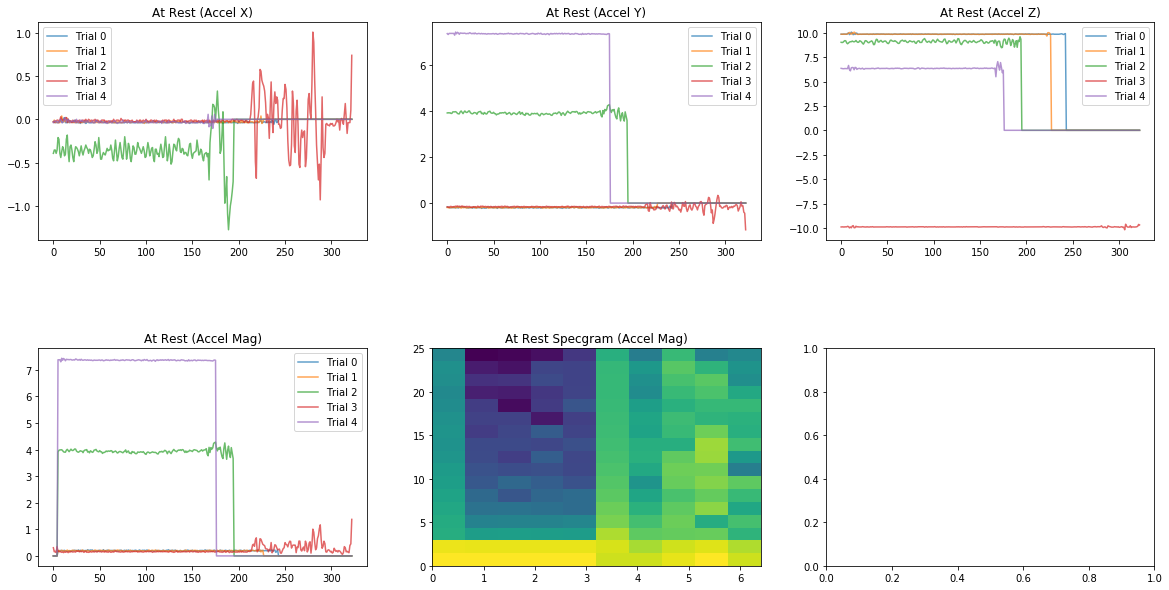

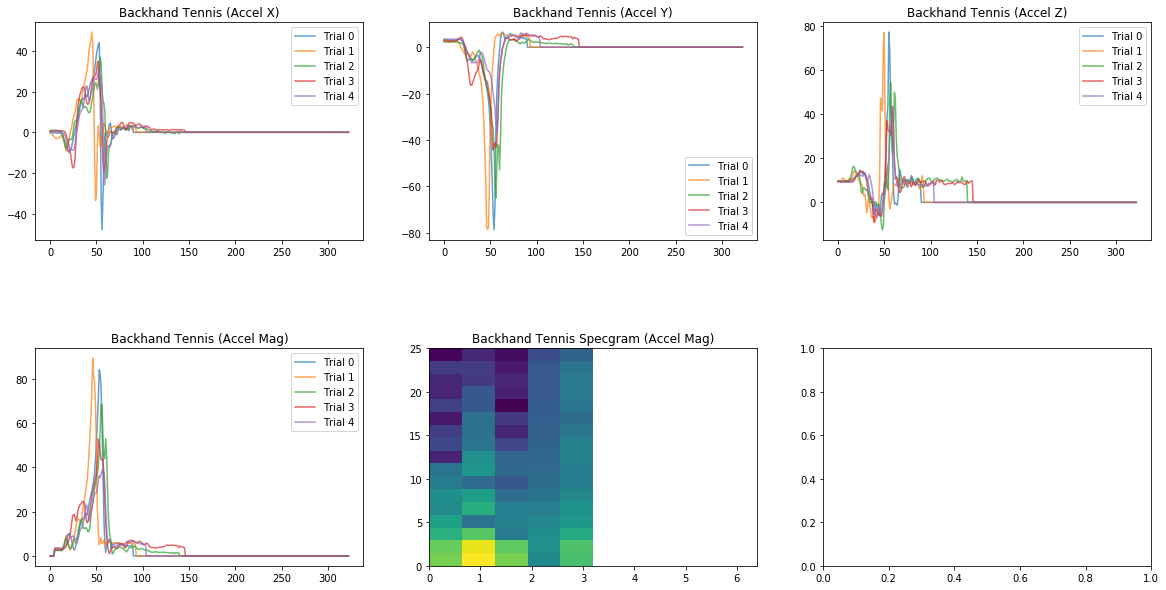

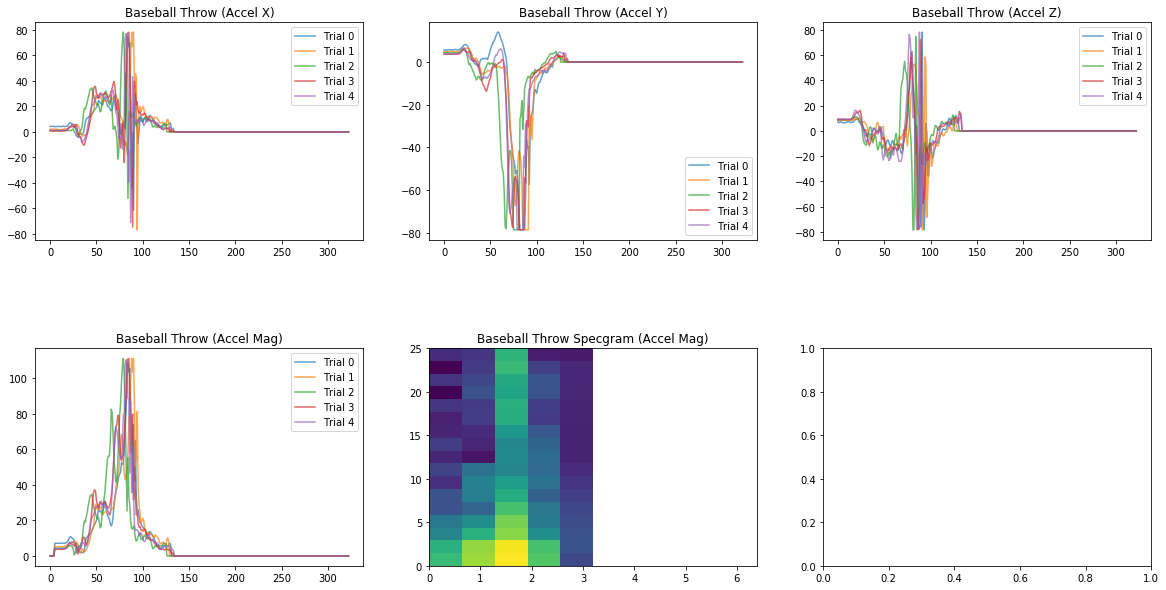

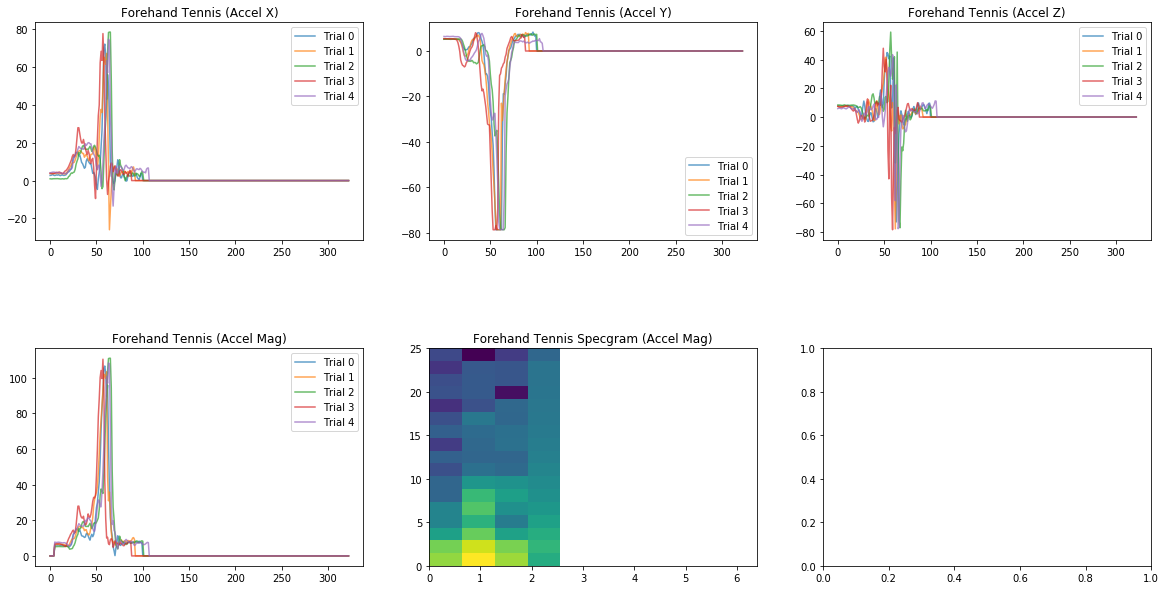

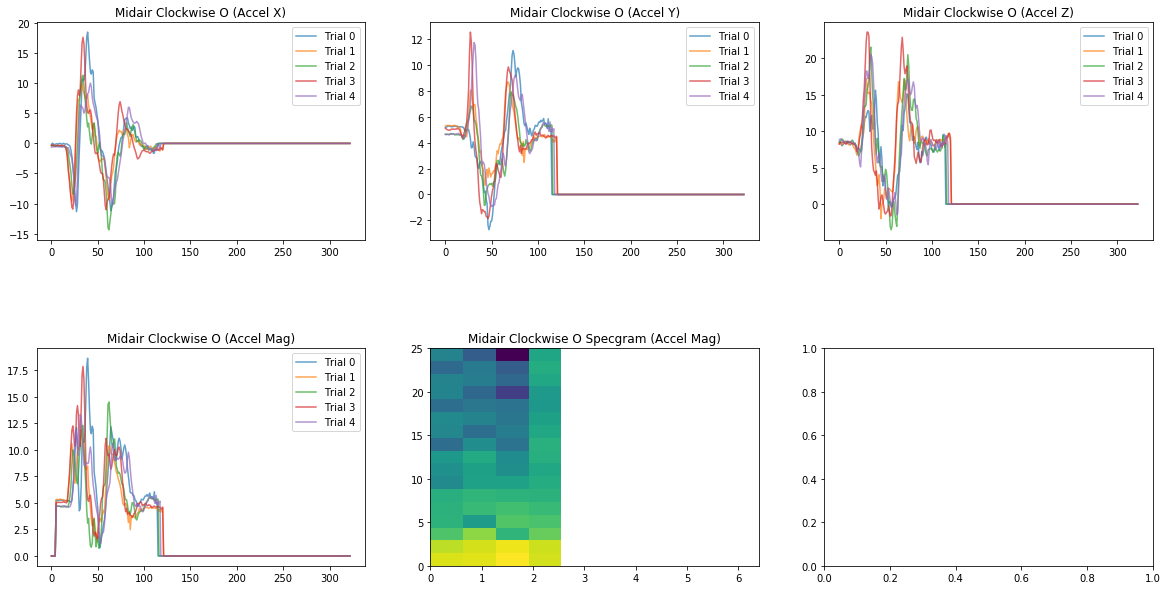

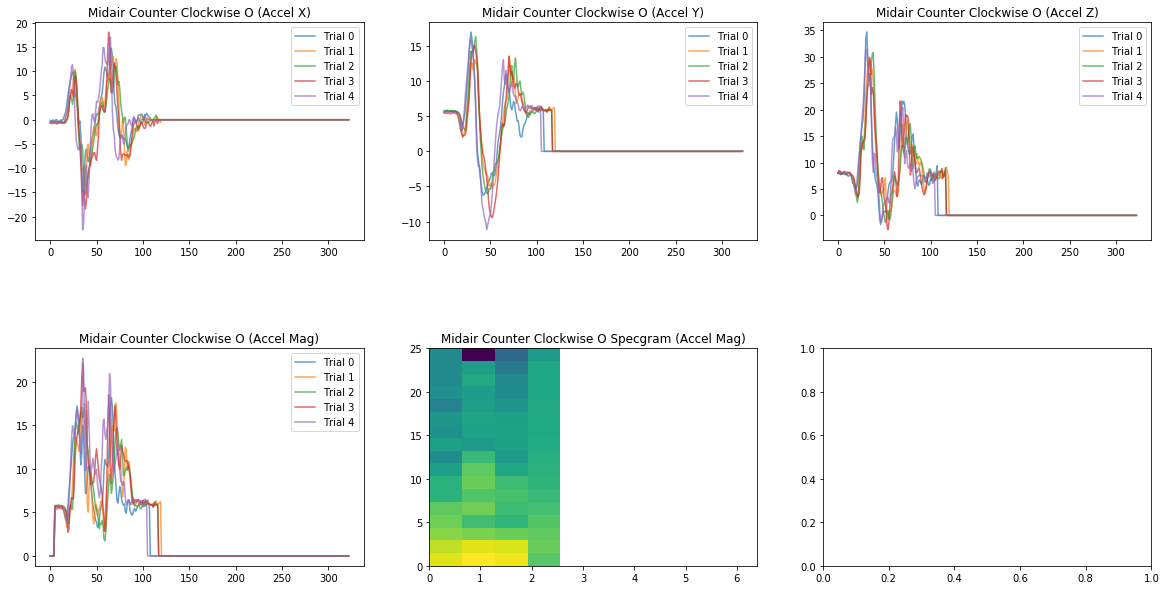

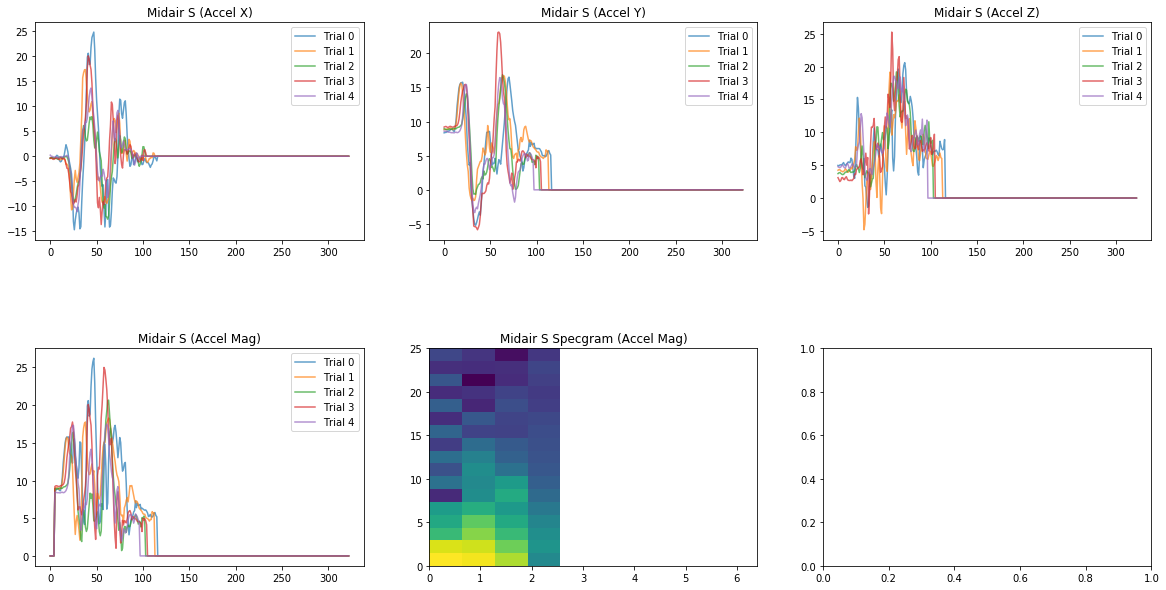

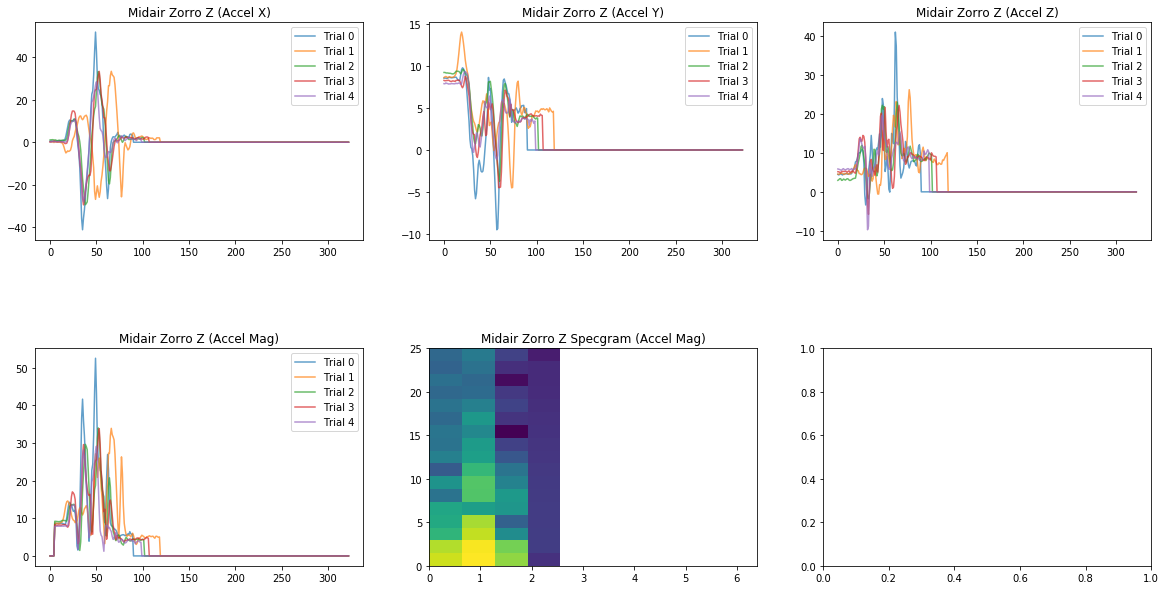

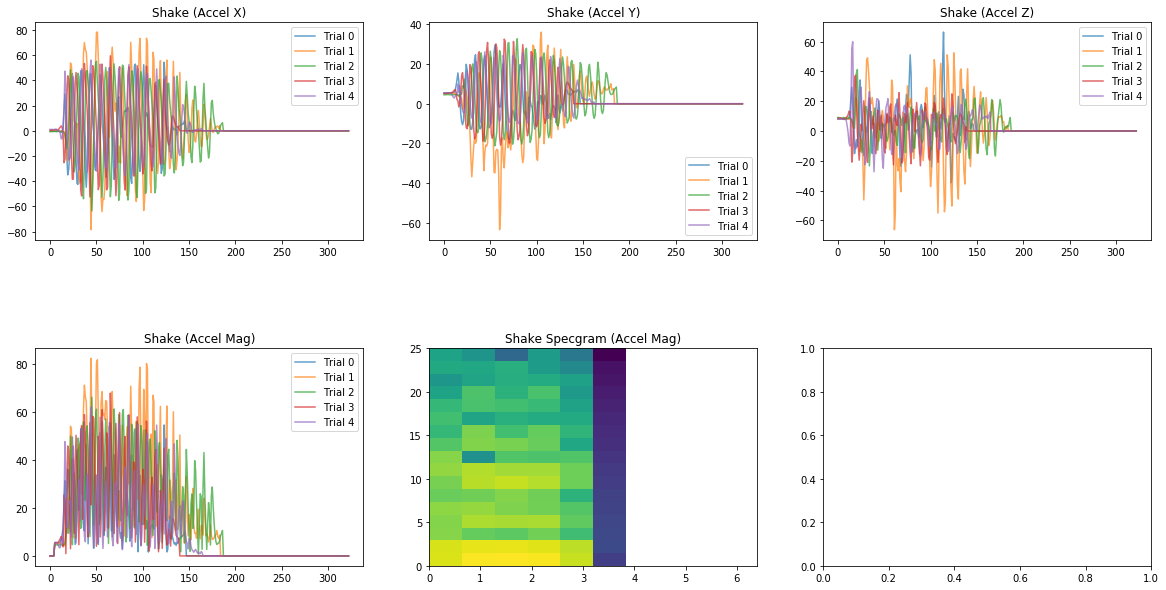

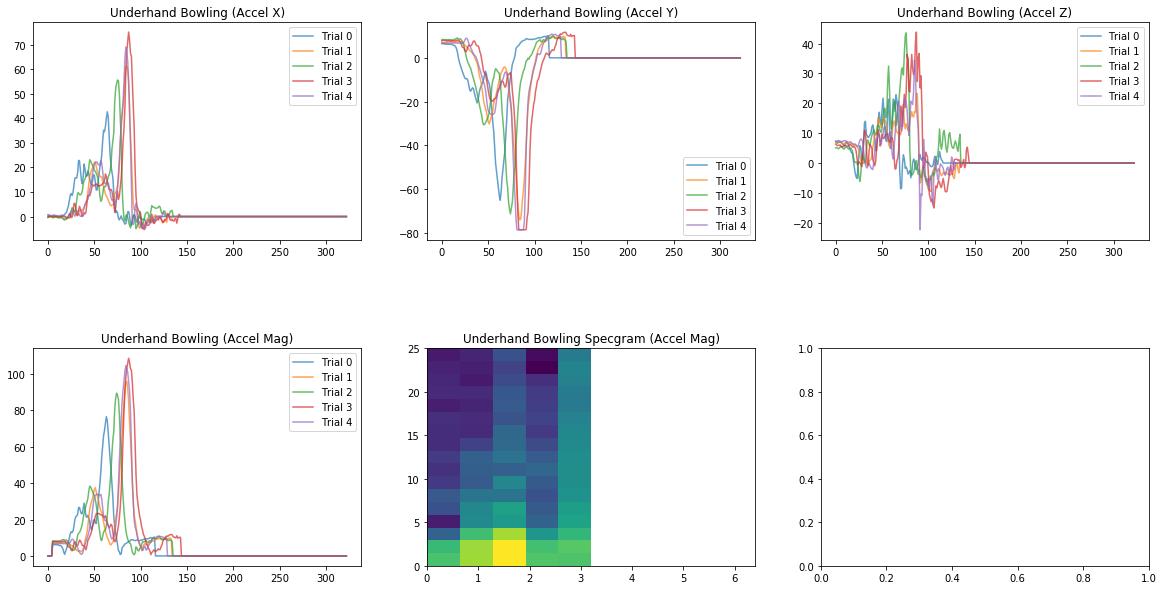

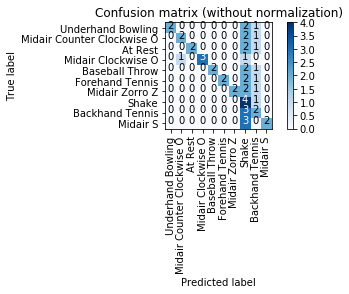

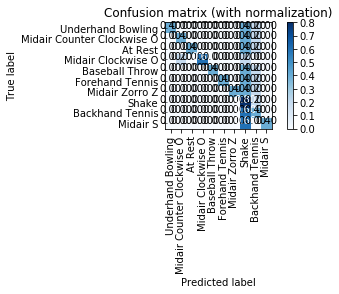

In [34]:
# jon's data set

createGestureViz(jonTrials)
jon_folds = makeFolds(jonTrials)
doSVM(jonTrials, jon_folds)


# Sandbox
Everything below here is a Sandbox for you to play. You could do this in another Jupyter Notebook but I often have some cells at the bottom of my notebook that let's me experiment with and play with Python and the numpy, scipy, etc. libraries. I've added some example playground cells that I used when making the assignment.

Feel free to delete all of these cells but I thought they might be informative for you.

In [ ]:
# Now, let's try to build an SVM using some of the features you brainstormed. 
# We're going to start with the simplest possible SVM using only one feature
# 
# Some nice resources:
#  - Official sci-kit learn (Start here!): http://scikit-learn.org/stable/modules/svm.html
#  - A simple classification example using scikit: https://dbaumgartel.wordpress.com/2014/03/10/a-scikit-learn-example-in-10-lines/
#  - A nice video overview of SVM: https://youtu.be/N1vOgolbjSc
#  
#
from sklearn import svm

numFolds = get_min_num_of_trials(mapGestureToTrials)
numGestures = len(mapGestureToTrials)
#numTrials = get_total_num_of_trials(mapGestureToTrials)
#foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials)
folds = makeFolds(mapGestureToTrials, 5)
    
gestureNames = list(mapGestureToTrials.keys())

# now build an SVM
# Currently training on folds 1-4 and testing on fold 0 (just for now)
foldIndex = 0
mapGestureNameToCorrectMatchCnt = dict()
mapGestureNameToPredictionResultList = dict()
trainingData = []
classLabels = []
for i in range(1, numFolds):
    # print("\tFold: ", i)
    fold = folds[i]
    for trial in fold:
        trainingData.append([trial.accel.mag.max(), trial.accel.x.max()])
        #trainingData = np.append(trainingData, [trial.accel.mag.max(), trial.accel.x.max()])
        #trainingData = np.append(trainingData, trial.accel.x.max())
        classLabels.append(trial.gestureName)

#for row in range(0,len(classLabels)):
#   print("gestureName={} values={}".format(classLabels[row], trainingData[row]))
        
# Setup SVM
#trainingData = trainingData.reshape(-1, 1) # for 1D input feature vectors, we have to reshape like this

# Traing our SVM
#print(trainingData)
clf = svm.SVC(degree=3)
clf.fit(trainingData, classLabels) 

# Test our SVM
# fold 0 will be our test fold
testFold = folds[0]
for trial in testFold:
    print("Attempting to predict: {}".format(trial.gestureName))
    svmPrediction = clf.predict([[trial.accel.mag.max(), trial.accel.x.max()]])
    print("SVM prediction: {}".format(svmPrediction[0]))

In [ ]:
%matplotlib notebook


#Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=900)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

time1 = np.arange(0,5,0.0001)
#time = np.arange(0,15,0.0001)
data1=np.sin(2*np.pi*300*time1)
data2=np.sin(2*np.pi*600*time1)
#data3=np.sin(2*np.pi*900*time1)
#data=np.append(data1,data2 )
#data=np.append(data,data3)
data = mapGestureToTrials['Baseball Throw'][0].accel.mag
#print(len(time))
#print(len(data))

trials = mapGestureToTrials['Baseball Throw']

NFFT = 32     # the length of the windowing segments
Fs = 50  # the sampling rate

# plot signal and spectrogram

for trial in trials:

    ax1 = plt.subplot(211)
    #plt.plot(time,data)   # for this one has to either undersample or zoom in 
    ax1.plot(trial.accel.mag, alpha=0.7)
    #plt.xlim([0,15])
    ax2 = plt.subplot(212 )  # don't share the axis
    Pxx, freqs, bins, im = ax2.specgram(data, NFFT=NFFT, Fs=Fs,noverlap=0)
plt.show() 

In [ ]:
# Now, we need to plot and explore the data. Come up with a shape matching approach 
# and a trained model approach (e.g., decision tree, SVM) to classify the gestures

# For example, here's how you would plot one of the signals
from random import randint
gestureNamesSorted = sorted(mapGestureToTrials.keys())
randomGestureName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gestureTrials = mapGestureToTrials[randomGestureName]
trialNum = 0
for trial in gestureTrials:
    axes.plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
    trialNum = trialNum + 1

# set the title and show the legend
axes.set_title(randomGestureName + " (Accel Mag)")
axes.legend()


In [ ]:
# Testing to see if the numpy 'where' method supports string matching
a = np.array(['apple', 'orange', 'apple', 'banana'])

indicesWhereThereAreApples = np.where(a == 'apple')

print (indicesWhereThereAreApples)
print (a[indicesWhereThereAreApples])

In [ ]:
# Playing around with classes in Python 3. Notice how just like in Javascript, you can add a new member variable
# just by starting to use it!

class DummyClass:
    def __init__(self, variable):
        self.testVar = variable
        

dummy = DummyClass(5)
print(dummy.testVar)
dummy.newVar = 7 # added a new member variable called newVar here. Cool!
print(dummy.newVar)
vars(dummy) # prints out the member variables of the class

In [ ]:
# Now let's plot all of the accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials), 2, figsize=(20, 5 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel Mag)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    index = index + 1


In [ ]:
# Experimenting with how folding and unfolding tuples work
testTuple = (1,2,3,4,5,6,7,8,9,10)
print(testTuple)
print(*testTuple)
print(*testTuple[5:])

In [ ]:
# Experimenting with how we delete things out of lists
import random
testDict = {"a":1, "c":3, "d":4}
a = list(testDict.keys())
print(a)
random.shuffle(a)
print(a)
del a[1]
print(a)

In [ ]:
# Playing around with how we can split up and combine lists in Python
testList = [1, 2, 3, 4, 5]
index = 4
print(testList[0:index] + testList[index + 1:5])

index = 3
print(testList[0:index] + testList[index + 1:5])

print(testList[index:])
print(testList[:index])


for idx, pt in enumerate(testList[:-2]):
    print(str(idx) + ': ' + str(pt))
    
for idx, pt in enumerate(testList):
    print("idx: " + str(idx))
    print(testList[:idx])
    print(testList[idx+1:])
    
    print(testList[:idx]  + testList[idx+1:])

In [ ]:
# playing around with numpy subtraction. In order for these operations to work
# the arrays must be of the same size
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([1, 2, 4, 5, 5])
print(np2 - np1)

np3 = [1, 2, 3]

# the (0,2) value tells pad to pad 0 times in the front of array
# and three times to the end of array. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
np3_resized = np.pad(np3, (0, 2), 'constant', constant_values=0)
print(np3_resized)
np3_resized - np2

In [ ]:
# Find Euclidean distance between two numpy vector arrays
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([5, 4, 3, 2, 1])

# First, we'll try numpy's way of determining Euclidean distance
# See: https://stackoverflow.com/a/1401828
npDist = np.linalg.norm(np2 - np1)
print(npDist)

# Next, we'll try scipy's way
# See: https://stackoverflow.com/a/21986532
from scipy.spatial import distance

scipyDist = distance.euclidean(np2,np1)
print(scipyDist)

In [ ]:
# detrend playground
from scipy import signal
a = np.random.rand(50) * 50
print(a)
b = np.array(range(0,50))
c = a + b

fig, axes = plt.subplots()
axes.plot(a)
axes.plot(b)
axes.plot(c, label="c (avg={:0.1f})".format(np.mean(c)))
c_detrended = signal.detrend(c)
axes.plot(c_detrended, label="c_detrended (avg={:0.1f})".format(np.mean(c_detrended)))
axes.legend()


In [ ]:
# Playing around with plotting confusion matrices
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = ["cat", "ant", "cat", "cat", "ant", "bird", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat", "bird"]
labels=["ant", "bird", "cat"]
cm = confusion_matrix(y_true, y_pred, labels)
plt.figure()
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()

In [ ]:
# kfold example

from sklearn.model_selection import KFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4],[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5,6,7,8])
kf = KFold(n_splits=4)
kf.get_n_splits(X)

print(kf)  

for train_index, test_index in kf.split(X, y):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]
   print("training on X: " )


In [ ]:
# spectrogram example


# Fixing random state for reproducibility
np.random.seed(19680801)

%matplotlib notebook


#Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=900)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

time1 = np.arange(0,5,0.0001)
time = np.arange(0,15,0.0001)
data1=np.sin(2*np.pi*300*time1)
data2=np.sin(2*np.pi*600*time1)
data3=np.sin(2*np.pi*900*time1)
data=np.append(data1,data2 )
data=np.append(data,data3)
print(len(time))
print(len(data))

NFFT = 200     # the length of the windowing segments
Fs = 500  # the sampling rate

# plot signal and spectrogram

ax1 = plt.subplot(211)
plt.plot(time,data)   # for this one has to either undersample or zoom in 
plt.xlim([0,15])
plt.subplot(212 )  # don't share the axis
Pxx, freqs, bins, im = plt.specgram(data, NFFT=NFFT,   Fs=Fs,noverlap=100, cmap=plt.cm.gist_heat)
plt.show() 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


dt = 0.0005
t = np.arange(0.0, 20.0, dt)
s1 = np.sin(2 * np.pi * 100 * t)
s2 = 2 * np.sin(2 * np.pi * 400 * t)

# create a transient "chirp"
mask = np.where(np.logical_and(t > 10, t < 12), 1.0, 0.0)
s2 = s2 * mask

# add some noise into the mix
nse = 0.01 * np.random.random(size=len(t))

x = s1 + s2 + nse  # the signal
NFFT = 1024       # the length of the windowing segments
Fs = int(1.0 / dt)  # the sampling frequency

# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage
# instance

ax_sample = plt.subplot(211)
plt.plot(t, x)
plt.subplot(212, sharex=ax_sample)
Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=900)
plt.show()